# La forma normale di Chomsky

In [ ]:
from liblet import Grammar, Production, Derivation, ProductionGraph, closure, prods2table, cyk2table

## Eliminazione ε-regole (Sez. 4.2.3.1)

In [ ]:
@closure
def replace_in_rhs(G, A):
    Ap = A + '’'
    prods = set()
    for B, β in G.P:
        if A in β:
            pos = β.index(A)
            rhs = β[:pos] + β[pos + 1:]
            if len(rhs) == 0: rhs = ('ε', )
            prods.add(Production(B, rhs))
            prods.add(Production(B, β[:pos] + (Ap, ) + β[pos + 1:]))
        else:
            prods.add(Production(B, β))    
    return Grammar(G.N | {Ap}, G.T, prods, G.S)

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> x A y A z
A -> a
""")

prods2table(replace_in_rhs(U, 'A'))

In [ ]:
@closure
def inline_ε_rules(G_seen):
    G, seen = G_seen
    for A in G.N - seen:
        if ('ε', ) in G.alternatives(A):
            return replace_in_rhs(G, A), seen | {A}
    return G, seen

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> A
A -> B C
B -> ε
C -> ε
""")

prods2table(inline_ε_rules((U, set()))[0])

In [ ]:
def eliminate_ε_rules(G):
    Gp, _ = inline_ε_rules((G, set()))
    prods = set(Gp.P)
    for Ap in Gp.N - G.N:
        A = Ap[:-1]
        for α in set(Gp.alternatives(A)) - {('ε', )}:
            prods.add(Production(Ap, α))
    return Grammar(Gp.N, Gp.T, prods, Gp.S)

In [ ]:
# esempio d'uso (fig. 4.10, pag. 120)

U = Grammar.from_string("""
S -> L a M
L -> L M 
L -> ε
M -> M M
M -> ε
""")

prods2table(eliminate_ε_rules(U))

## Eliminazione regole unitarie (Sez. 4.2.3.2)

In [ ]:
def eliminate_unit_rules(G):
    @closure
    def _eliminate_unit_rules(G_seen):
        G, seen = G_seen
        for P in set(filter(Production.such_that(rhs_len = 1), G.P)) - seen:
            A, (B, ) = P
            if B in G.N:            
                prods = (set(G.P) | {Production(A, α) for α in G.alternatives(B)}) - {P}
                return Grammar(G.N, G.T, prods, G.S), seen | {P}
        return G, seen
    return _eliminate_unit_rules((G, set()))[0]

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> A
A -> B
B -> A | b
""")

prods2table(eliminate_unit_rules(U))

### Un esempio più elaborato

In [ ]:
# fig. 4.6, pag. 112

G = Grammar.from_string("""
Number -> Integer | Real
Integer -> Digit | Integer Digit
Real -> Integer Fraction Scale
Fraction -> . Integer
Scale -> e Sign Integer | Empty
Digit -> 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
Sign -> + | -
Empty -> ε
""")

In [ ]:
# fig. 4.12, pag. 120 (a meno di Empty’)

prods2table(eliminate_ε_rules(G))

In [ ]:
# fig. 4.13, pag. 121

Gp = eliminate_unit_rules(eliminate_ε_rules(G))
prods2table(Gp)

## Eliminare regole/simboli non produttive e  non raggiungibili (Sez. 2.9.5.1-2)

In [ ]:
from L09 import remove_unproductive_unreachable

In [ ]:
# fig. 4.14, pag. 122

Gp_clean = remove_unproductive_unreachable(Gp)
prods2table(Gp_clean)

## Riduzione in forma normale

### Caso $A\to \alpha a \beta$

In [ ]:
def transform_nonsolitary(G):
    prods = set()
    for A, α in G.P:
        if len(α) > 1 and set(α) & G.T:
            rhs = []
            for x in α:
                if x in G.T:
                    N = 'N{}'.format(x)
                    prods.add(Production(N, (x, )))
                    rhs.append(N)
                else:
                    rhs.append(x)
            prods.add(Production(A, rhs))
        else:            
            prods.add(Production(A, α))
    return Grammar(G.N | {A for A, α in prods}, G.T, prods, G.S)

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> x S y S x
""")

prods2table(transform_nonsolitary(U))

### Caso $A\to X_1 X_2\ldots X_n$

In [ ]:
def make_binary(G):
    prods = set()
    for A, α in G.P:
        if len(α) > 2:
            Ai = '{}{}'.format(A, 1)
            prods.add(Production(Ai, α[:2]))
            for i, Xi in enumerate(α[2:-1], 2):
                prods.add(Production('{}{}'.format(A, i), (Ai, Xi)))
                Ai = '{}{}'.format(A, i)
            prods.add(Production(A, (Ai, α[-1])))
        else:
            prods.add(Production(A, α))
    return Grammar(G.N | {A for A, α in prods}, G.T, prods, G.S)

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> A B C D
""")

prods2table(make_binary(U))

### Di nuovo, l'esempio più elaborato

In [ ]:
# fig. 4.15, pag. 123 (rinominando alcuni non terminali)

G_cnf = make_binary(transform_nonsolitary(Gp_clean))
prods2table(G_cnf)

# Parsing CYK con  G in forma CNF

In [ ]:
from L09 import cyk

In [ ]:
# fig. 4.16, pag. 123

INPUT = '32.5e+1'
R = cyk(G_cnf, INPUT)
cyk2table(R)

## Una derivazione leftmost

In [ ]:
def get_leftmost_prods(G, R, INPUT):
    def prods(X, i, l):
        if l == 1:
            return [G.P.index(Production(X, (INPUT[i - 1],)))]
        for A, (B, C) in filter(Production.such_that(lhs = X, rhs_len = 2), G.P):
            for k in range(1, l):
                if B in R[(i, k)] and C in R[(i + k, l - k)]:
                    return [G.P.index(Production(A, (B, C)))] + prods(B, i, k) + prods(C, i + k, l - k)
    return prods(G.S, 1, len(INPUT))            

In [ ]:
prods = get_leftmost_prods(G_cnf, R, INPUT)
prods

[41, 33, 15, 14, 21, 18, 7, 29, 40, 13, 17, 3, 5]

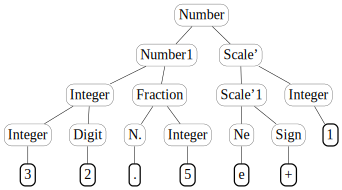

In [ ]:
d = Derivation(G_cnf).leftmost(prods)
ProductionGraph(d)    

## E il parsing in G (non in CNF)? (Sez. 4.2.6)

Un primo requisito, per poter effettuare il parsing secondo le produzioni della grammatica originale è non eliminare i simboli improduttivi e irraggiungibili.

Quindi va prodotta una tabella a partire dalla grammatica non ripulita e vanno aggiunte in calce le ϵ-produzioni.

Ma non basta: il resto si ottiene a partire dalla soluzione degli esercizi…

In [ ]:
# Non effettuiamo la pulizia

Gp_cnf = transform_nonsolitary(make_binary(Gp))
prods2table(Gp_cnf)

In [ ]:
# Otteniamo Rp tramite il parsing rispetto alla grammatica non ripulita Gp_cnf

INPUT = '32.5e+1'
Rp = cyk(Gp_cnf, INPUT)

In [ ]:
# Calcoliamo l'insieme dei simboli A tali che A -> ϵ

Rε = {A for A in Gp_cnf.N if ('ε', ) in Gp_cnf.alternatives(A)}

In [ ]:
# Li aggiungiamo in fondo alla tabella

for i in range(len(INPUT) + 2): Rp[(i, 0)] = Rε

In [ ]:
# fig. 4.17, pag. 126

cyk2table(Rp)

In [ ]:
# e il resto deriva dagli esercizi…

# <span style="color: red;">Esercizi per casa</span>

I seguenti esercizi sono elencati in ordine di difficoltà: il primo è elementare, il secondo è più complesso, ma di fatto è l'implementazione di un algoritmo descritto nel libro di testo; l'ultimo esercizio ha un grado di difficoltà non banale.

## Una derivazione rightmost

Scrivete la funzione `get_rightmost_prods` che restituisca le produzioni di una derivazione *rightmost*. 

Per farlo, ispiratevi alla funzione `get_leftmost_prods`, riflettendo sul fatto che se la grammatica è in CNF, l'unica differenza è che per le regole non unitarie $A\to BC$ basta espandere prima $B$ di $C$ (al contrario di quello che avviene per le derivazioni *leftmost*).

## Una derivazione (leftmost) nella grammatica originale
  
  
Scrivete la funzione `get_original_leftmost_prods` che restituisca le produzioni di una deivazione *leftmost* nella grammatica originale (non in CNF).

Per farlo dovrete implementate l'algoritmo descritto nella Sez. 4.2.6 (e 4.2.1) che produce l'albero di parsing a partire dalla tabella `Rp` ottenuta nella sezione precedente.

Tale algoritmo si basa sulla capacità di determinare se una data forma sentenziale ω deriva una sottostringa dell'input $s_i \dots s_{i + l}$ e, qualora lo faccia, nel calcolare inoltre che parte della sottostringa sia derivata da ciascun simbolo di ω (si tratta di quanto descritto in fondo a 126 e nei due punti all'inizio di pag 127).

Una volta scritta la funzione ricorsiva `derives(ω, i, l)` che implementi la funzionalità appena descritta, seguendo l'algoritmo descritto a partire da pag. 115 è abbastanza semplice implementare `get_original_leftmost_prods`, che restituisce una derivazione *leftmost*.
 
 
## Tutte le derivazioni leftmost (nella grammatica originale)

Se la grammatica è ambigua, l'algoritmo CYK determinerà più derivazioni (leftmost) differenti.

Scrivere la funzione `get_all_original_leftmost_prods` che restituisca tutti le possibli derivazioni, non soltanto una di esse. 

Per farlo potreste dapprima implementare una funzione `all_derives(ω, i, l)` che (in analogia a `derives(ω, i, l)`) determini se la forma sentenziale ω deriva una sottostringa dell'input $s_i \dots s_{i + l}$ e, qualora lo faccia, restituisca però tutte le possibili suddivisioni in cui la sottostringa può essere derivata dai simboli di ω.